# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [104]:
# all import statements needed for the project, for example:

import math
import re
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy
from math import sin, cos, sqrt, atan2, radians
import datetime
import warnings
import matplotlib
warnings.filterwarnings('ignore')

In [2]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

SHP = gpd.read_file("taxi_zones.shp")

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [3]:
#prepare for the SHP data
def SHP_prepare(SHP):
    SHP['PULocationID'] = SHP['LocationID']
    SHP['DOLocationID'] = SHP['LocationID']
    SHP['pick_lon'] = SHP['geometry'].to_crs(4326).centroid.x
    SHP['pick_lat'] = SHP['geometry'].to_crs(4326).centroid.y
    SHP['drop_lon'] = SHP['geometry'].to_crs(4326).centroid.x
    SHP['drop_lat'] = SHP['geometry'].to_crs(4326).centroid.y
    return SHP

SHP_trans = SHP_prepare(SHP)


In [4]:
#get the coordinates if there is only locationID and append the coordinate column to the dataframe
def get_coord(df, SHP):

    #drop the records with null values in locationID
    try: 
        df.dropna(axis=0, how= 'any', subset = ['PULocationID', 'DOLocationID'], inplace=True)
    except:
        pass

    if ('PULocationID' in df.columns) and ('DOLocationID' in df.columns): #if only the zone ID is given
        df = pd.merge(df, SHP[['PULocationID', 'pick_lon', 'pick_lat']], left_on = 'PULocationID', right_on = 'PULocationID', how = 'left')
        df = pd.merge(df, SHP[['DOLocationID', 'drop_lon', 'drop_lat']], left_on = 'DOLocationID', right_on = 'DOLocationID', how = 'left')
        
    df.dropna(axis=0, how= 'any', subset = ['pick_lon', 'pick_lat', 'drop_lon', 'drop_lat'], inplace=True)
    df = df.loc[(df['pick_lon'] <= -73.717047) & (df['pick_lon'] >= -74.242330) & (df['drop_lon'] <= -73.717047) & (df['drop_lon'] >= -74.242330) 
            & (df['pick_lat'] >= 40.560445) & (df['pick_lat'] <= 40.908524) & (df['drop_lat'] >= 40.560445) & (df['drop_lat'] <= 40.908524)]
    return df
         




In [5]:
#use a formula to calculate the distance manually
def calculate_distance(pick_lon, pick_lat, drop_lon, drop_lat):
    R = 6373.0 #approximate earth radius

    lat1 = radians(pick_lat)
    lon1 = radians(pick_lon)
    lat2 = radians(drop_lat)
    lon2 = radians(drop_lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    #formula for calculating the distance (km)
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return (R * c)/1.60934 #return miles

    

In [6]:
#add the distance we have just calculated with the formula above
def add_distance_column(df):
    df['distance'] = df[["pick_lon", "pick_lat", "drop_lon", "drop_lat"]].apply(lambda x: calculate_distance(*x), axis = 1)

    return df


### Processing Uber Data

In [7]:
def load_and_clean_uber_data():
    u_df=pd.read_csv('uber_rides_sample.csv')
    u_df=u_df.rename(columns={'pickup_longitude':'pick_lon','pickup_latitude':'pick_lat','dropoff_longitude':'drop_lon','dropoff_latitude':'drop_lat','pickup_datetime':'tpep_pickup_datetime'})

    u_df.dropna(axis=0, how='any', inplace = True)

    u_df = u_df.loc[~(u_df['fare_amount'] <= 0)]

    u_df.dropna(axis=0, how= 'any', subset = ['pick_lon', 'pick_lat', 'drop_lon', 'drop_lat'], inplace=True)
    u_df = u_df.loc[(u_df['pick_lon'] <= -73.717047) & (u_df['pick_lon'] >= -74.242330) & (u_df['drop_lon'] <= -73.717047) & (u_df['drop_lon'] >= -74.242330) 
            & (u_df['pick_lat'] >= 40.560445) & (u_df['pick_lat'] <= 40.908524) & (u_df['drop_lat'] >= 40.560445) & (u_df['drop_lat'] <= 40.908524)]

    u_df['tpep_pickup_datetime']=u_df['tpep_pickup_datetime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S %Z'))
    u_df['sevenday']=u_df['tpep_pickup_datetime'].apply(lambda x: x.isoweekday()) #add feature indicating the weekday


    u_df = u_df.loc[u_df['passenger_count'] <= 10] #eliminate the abnormal customer numbers

    u_df.reset_index(drop = True, inplace = True) #reset index
    
    return u_df[['fare_amount', 'tpep_pickup_datetime', 'pick_lon', 'pick_lat', 'drop_lon', 'drop_lat', 'passenger_count','sevenday']]

In [8]:
#call the above functions to process uber data
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data()
    add_distance_column(uber_dataframe)
    uber_dataframe['tpep_pickup_datetime'] = uber_dataframe['tpep_pickup_datetime'].astype('datetime64[ns]')
    return uber_dataframe



In [9]:
#find the sample size of uber ride in each month and use this in future sampling in taxi data
uber_data = get_uber_data()
sample_dic = uber_data.groupby(uber_data['tpep_pickup_datetime'].dt.strftime('%Y-%m')).size().to_dict()

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [10]:
def find_taxi_parquet_links():
    #construct the regrex expression list which contains the time in which we would like to analyze (2009-01 to 2015-06)
    regrexlist = []
    for y in range(2009, 2015):
        for m in range(1, 13):
            if m < 10:
                m = '0' + str(m)
            regrexlist.append(str(y) + '-' + str(m))
    for m in range(1, 7):
        regrexlist.append(str(2015) + '-' + '0' + str(m))

    #get all the urls and filter with the regrex above
    TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
    soup = bs4.BeautifulSoup(requests.get(TAXI_URL).content, 'html.parser')
    a = soup.find_all('a')
    res = []
    for ele in a:
        try:
            if ele['title'] == 'Yellow Taxi Trip Records' :
                for reg in regrexlist:
                    if re.search(reg, ele['href']) is not None:
                        res.append(ele['href'])
        except:
            pass

    return sorted(res) #so the links will be in the order of time(ascending)




In [ ]:
def get_and_clean_month_taxi_data(url, sample_dic):
    response = requests.get(url, stream=True)
    with open(f"{url[64:71]}.parquet", "wb") as f:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
    df = pd.read_parquet(f"{url[64:71]}.parquet", engine='pyarrow')

    #deal with different years data, normalize the column names
    if '2009' in url[64:71]: #in 2009
        df.rename({
            'vendor_name': 'VendorID', 
            'Trip_Pickup_DateTime': 'tpep_pickup_datetime',
            'Trip_Dropoff_DateTime': 'tpep_dropoff_datetime',
            'Passenger_Count': 'passenger_count',
            'Trip_Distance': 'trip_distance',
            'Start_Lon': 'pick_lon',
            'Start_Lat': 'pick_lat',
            'Rate_Code': 'RatecodeID',
            'store_and_forward': 'store_and_fwd_flag',
            'End_Lon': 'drop_lon',
            'End_Lat': 'drop_lat',
            'Payment_Type': 'payment_type',
            'Fare_Amt': 'fare_amount',
            'surcharge': 'extra',
            'mta_tax': 'mta_tax',
            'Tip_Amt': 'tip_amount',
            'Tolls_Amt': 'tolls_amount',
            'Total_Amt': 'total_amount'}, 
            axis = "columns", inplace = True)
    elif '2010' in url[64:71]: #in 2010
        df.rename({
            'vendor_id': 'VendorID',
            'pickup_datetime': 'tpep_pickup_datetime',
            'dropoff_datetime': 'tpep_dropoff_datetime',
            'pickup_longitude': 'pick_lon',
            'pickup_latitude': 'pick_lat',
            'rate_code': 'RatecodeID',
            'dropoff_longitude': 'drop_lon',
            'dropoff_latitude': 'drop_lat',
            'surcharge': 'extra'}, 
            axis = "columns", inplace = True)
    else:
        pass
    

    df = add_distance_column(get_coord(df, SHP))
    df = df.loc[~(df['passenger_count'] <= 0)]
    df = df.loc[~(df['trip_distance'] <= 0)]
    df['distance'].mask(df['distance'] == 0, df['trip_distance'], inplace= True)
    df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
            'pick_lon', 'pick_lat', 'drop_lon', 'drop_lat', 'distance', 'tip_amount', 'trip_distance']]
    df = df.sample(n = sample_dic[url[64:71]])

    return df




def get_and_clean_taxi_data(sample_dic):
    all_taxi_dataframes = []
    
    all_par_urls = find_taxi_parquet_links()
    for par_url in all_par_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(par_url, sample_dic)
        
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data





sampled_data = get_and_clean_taxi_data(sample_dic)

    

    


    

In [ ]:
sampled_data.reset_index(inplace = True)
sampled_data.to_csv('sampled_data.csv', encoding='utf-8')

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [11]:
def clean_month_weather_data_hourly(csv_file):
    
    data=pd.read_csv(csv_file)
    
    #由于这是一个聚焦于小时的数据库，删去了所有daily和month的列
    data=data.drop(data.columns[24:112],axis=1)
    
    #有几列只有一个值，没有意义，我全都删了
    data=data.drop(columns=['STATION','LATITUDE','LONGITUDE','ELEVATION','NAME','BackupDirection','BackupDistance','BackupDistanceUnit','BackupElements','BackupElevation','BackupEquipment','BackupLatitude','BackupLongitude','BackupName','WindEquipmentChangeDate'])
    
    #有几列可用的数值实在太少，全都删去
    data=data.drop(columns=['HourlyPresentWeatherType','HourlySkyConditions','HourlyStationPressure','HourlyWetBulbTemperature','HourlyPressureChange','HourlyPressureTendency','HourlyWindGustSpeed'])
    

    #对于source这一列来说，只有取4才有意义，删去取0的行，然后将这一列删去
    data=data[data['SOURCE']!="O"]
    data=data.drop(columns=['SOURCE'])
    
    #HourlyWindDirection这一项有一些VRB删去
    data=data[data['HourlyWindDirection']!="VRB"]
    data[['HourlyWindDirection']]=data[['HourlyWindDirection']].astype('float64')
    
    #HourlyDewPointTemperature这一项有一些带s修改
    data['HourlyDewPointTemperature']=data['HourlyDewPointTemperature'].apply( lambda x: str(x)[:-1] if str(x)[-1]=='s' else x)
    data[['HourlyDewPointTemperature']]=data[['HourlyDewPointTemperature']].astype('float64')
    
    #HourlySeaLevelPressure这一项有一些带着s的修改
    data['HourlySeaLevelPressure']=data['HourlySeaLevelPressure'].apply( lambda x: str(x)[:-1] if str(x)[-1]=='s' else x)
    data[['HourlySeaLevelPressure']]=data[['HourlySeaLevelPressure']].astype('float64')
  
    #HourlyDryBulbTemperature这一项有一些带着s的修改
    data['HourlyDryBulbTemperature']=data['HourlyDryBulbTemperature'].apply( lambda x: str(x)[:-1] if str(x)[-1]=='s' else x)
    data[['HourlyDryBulbTemperature']]=data[['HourlyDryBulbTemperature']].astype('float64')

    #HourlyVisibility这一项有一些带着V的要修改，不过这一列在daily里面也没让求取，不知道后续到底要干什么，但先予以保留
    data['HourlyVisibility']=data['HourlyVisibility'].apply( lambda x: str(x)[:-1] if str(x)[-1]=='V' else x)
    data[['HourlyVisibility']]=data[['HourlyVisibility']].astype('float64')

    #这一列是空白的需要加上0，去掉所有是T的
    data=data[data['HourlyPrecipitation']!="T"]
    data['HourlyPrecipitation']=data['HourlyPrecipitation'].apply(lambda x: 0 if x=='' else x)

    #增加了一个去掉date中的“T”字母
    data['DATE']=data['DATE'].apply(lambda x: str(x).replace('T',' '))

    #换一些列名
    data.rename(columns={'DATE':'tpep_pickup_datetime'}, inplace = True)

    #删除空缺行
    data=data.dropna(axis=0,how='any')
    
    #重新排列了一下index
    data.reset_index(drop=True, inplace=True)
    
    return data

In [12]:
def clean_month_weather_data_daily(csv_file):
    data=clean_month_weather_data_hourly(csv_file)
    df=pd.DataFrame()
    
    #提取日期并删除重复项
    df['Date']=data['tpep_pickup_datetime']
    df['Date']=df['Date'].apply(lambda x : x[0:10])
    df['Date']=df.drop_duplicates()
    df=df.dropna(axis=0,how='any')
    
    #重新排列了一下index
    df.reset_index(drop=True, inplace=True)
    df.set_index(['Date'],inplace=True)


    #计算DailyAverageDewPointTemperature
    data['Daily']=data['tpep_pickup_datetime'].apply(lambda x : x[0:10])
    data_group=data.groupby('Daily')
    DailyAverageDewPointTemperature=data_group.mean().loc[ : ,'HourlyDewPointTemperature']
    df['DailyAverageDewPointTemperature']=DailyAverageDewPointTemperature

    #计算DailyAverageDryBulbTemperature
    DailyAverageDryBulbTemperature=data_group.mean().loc[ : , 'HourlyDryBulbTemperature']
    df['DailyAverageDryBulbTemperature']=DailyAverageDryBulbTemperature
    
    #计算DailyMaximumDryBulbTemperature
    DailyMaximumDryBulbTemperature=data_group.max().loc[:,'HourlyDryBulbTemperature']
    df['DailyMaximumDryBulbTemperature']=DailyMaximumDryBulbTemperature
    
    #计算DailyMinimumDryBulbTemperature
    DailyMinimumDryBulbTemperature=data_group.min().loc[ : , 'HourlyDryBulbTemperature']
    df['DailyMinimumDryBulbTemperature']=DailyMinimumDryBulbTemperature

    #计算DailyAverageRelativeHumidity
    DailyAverageRelativeHumidity=data_group.mean().loc[ : , 'HourlyRelativeHumidity']
    df['DailyAverageRelativeHumidity']=DailyAverageRelativeHumidity

    #计算DailyAverageSeaLevelPressure
    DailyAverageSeaLevelPressure=data_group.mean().loc[ : , 'HourlySeaLevelPressure']
    df['DailyAverageSeaLevelPressure']=DailyAverageSeaLevelPressure

    #计算DailyAverageWindSpeed
    DailyAverageWindSpeed=data_group.mean().loc[ : , 'HourlyWindSpeed']
    df['DailyAverageWindSpeed']=DailyAverageWindSpeed
    
    #计算DailyPeakWindSpeed
    DailyPeakWindSpeed=data_group.max().loc[ : , 'HourlyWindDirection']
    df['DailyPeakWindSpeed']=DailyPeakWindSpeed

    #加入一个日期列 这里的日期应该换成对应的天才是对的，但是暂时无影响，先放着
    DATE=data_group.max().loc[ : , 'tpep_pickup_datetime']
    df['tpep_pickup_datetime']=DATE

    #计算DailyPeakWindDirection 这个我没想出来方法如何计算，如果之后需要再回头考虑，其余变量同理
    
    return df

In [13]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    weather_csv_files=[]
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    for i in range(6):
        weather_csv_files.append(r'{year}_weather.csv'.format(year=i+2009))

    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)

    #重新调整一下index 
    hourly_data.reset_index(drop=True, inplace=True)
    daily_data.reset_index(drop=True, inplace=True)

    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [84]:
# taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()
taxi_data = pd.read_csv('sampled_data.csv')
# taxi_data['pickup_datetime'] = taxi_data['pickup_datetime'].astype('datetime64[ns]')

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [16]:

db = sqlalchemy.create_engine('sqlite:///project.db', echo=False)

import logging
sqllogger = logging.getLogger("sqlalchemy.engine.Engine")
formatter = logging.Formatter("[sqlalchemy] %(message)s")
# sqllogger.handlers[0].setFormatter(formatter)

from sqlalchemy.orm import declarative_base

Base = declarative_base()

In [18]:

from sqlalchemy import Column, Integer,  Date, REAL, Text, Float

class TAXI_TRIPS_SCHEMA(Base):
    __tablename__ = "taxi"
    __table_args__ = {'extend_existing': True}  
    
    taxiId = Column(Integer, primary_key=True)
    tpep_pickup_datetime = Column(Float)
    tpep_dropoff_datetime = Column(Float)
    trip_distance = Column(Float)
    pick_lon= Column(Float)
    pick_lat= Column(Float)
    drop_lon= Column(Float)
    drop_lat= Column(Float)
    distance= Column(Float)
    tip_amount= Column(Float)
    passenger_count= Column(Integer)



class UBER_TRIPS_SCHEMA(Base):
    __tablename__ = "uber" 
    __table_args__ = {'extend_existing': True} 
    
    uberId = Column(Integer, primary_key=True)
    pickup_datetime = Column(Date)
    fare_amount= Column(Float)
    pick_lon= Column(Float)
    pick_lat= Column(Float)
    drop_lon= Column(Float)
    drop_lat= Column(Float)
    distance = Column(Float)
    passenger_count= Column(Integer)
    sevenday=Column(Integer)





class HOURLY_WEATHER_SCHEMA(Base):
    __tablename__ = "hourly"
    __table_args__ = {'extend_existing': True}  
    
    REM = Column(Text, primary_key=True)
    DATE =Column(Text)
    REPORT_TYPE=Column(Text)
    HourlyAltimeterSetting= Column(Float)
    HourlyDewPointTemperature= Column(Float)
    HourlyDryBulbTemperature= Column(Float)
    HourlyRelativeHumidity= Column(Float)
    HourlySeaLevelPressure= Column(Float)
    HourlyVisibility = Column(Float)
    HourlyWindDirectiont= Column(Float)
    HourlyWindSpeed= Column(Float)
    HourlyPrecipitation=Column(Float)



class DAILY_WEATHER_SCHEMA(Base):
    __tablename__ = "daily"  
    __table_args__ = {'extend_existing': True}
    
    DATE = Column(Text, primary_key=True)
    DailyAverageDewPointTemperature= Column(Float)
    DailyAverageDryBulbTemperature= Column(Float)
    DailyMaximumDryBulbTemperature= Column(Float)
    DailyMinimumDryBulbTemperature= Column(Float)
    DailyAverageRelativeHumidity= Column(Float)
    DailyAverageSeaLevelPressure = Column(Float)
    DailyAverageWindSpeed= Column(REAL)
    DailyPeakWindSpeed= Column(REAL)

Base.metadata.create_all(db, checkfirst=True)


In [19]:
# create that required schema.sql file
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS TAXI (
   taxiId INTEGER PRIMARY KEY AUTOINCREMENT,
   tpep_pickup_datetime DATE,
   tpep_dropoff_datetime DATE,
   trip_distance Float,
   pick_lon Float,
   pick_lat Float,
   drop_lon Float,
   drop_lat Float,
   distance Float,
   tip_amount Float
   passenger_count INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS UBER (
   uberId INTEGER PRIMARY KEY AUTOINCREMENT,
   fare_amount REAL,
   pickup_datetime DATE,
   distance Float,
   pick_lon Float,
   pick_lat Float,
   drop_lon Float,
   drop_lat Float,
   distance Float,
   passenger_count INTEGER
);
"""

HOURLY_WEATHER_SCHEMA="""
CREATE TABLE IF NOT EXISTS HOURLY (
   REM TEXT PRIMARY KEY, 
   DATE TEXT,
   REPORT_TYPE	TEXT,
   HourlyAltimeterSetting Float,
   HourlyDewPointTemperature Float,
   HourlyDryBulbTemperature Float,
   HourlyRelativeHumidity	Float,
   HourlySeaLevelPressure Float,
   HourlyVisibility Float,
   HourlyWindDirection Float,
   HourlyWindSpeed Float,
   HourlyPrecipitation Float

);
"""

DAILY_WEATHER_SCHEMA="""
CREATE TABLE IF NOT EXISTS DAILY(
   
   DATE TEXT PRIMARY KEY,
   DailyAverageDewPointTemperature Float,
   DailyAverageDryBulbTemperature Float,
   DailyMaximumDryBulbTemperature Float,
   DailyMinimumDryBulbTemperature Float,
   DailyAverageRelativeHumidity Float,
   DailyAverageSeaLevelPressure Float,
   DailyAverageWindSpeed Float,
   DailyPeakWindSpeed Float
);
"""


with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [20]:
pd.io.sql.to_sql(uber_data,'uber',db, if_exists='replace',index=False)
pd.io.sql.to_sql(taxi_data,'taxi',db, if_exists='replace',index=False)
pd.io.sql.to_sql(hourly_weather_data,'hourly',db, if_exists='replace',index=False)
pd.io.sql.to_sql(daily_weather_data,'daily',db, if_exists='replace',index=False)

1251

In [21]:
#it runs correctly, which proves the schema file has correct syntax
!sqlite3 project.db < schema.sql

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._
* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [22]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f: 
        f.write(query)

##### Question1

In [23]:
#For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
QUERY_1 = """
SELECT strftime('%H',tpep_pickup_datetime) HOUR, count(distance) from taxi GROUP BY strftime ('%H',tpep_pickup_datetime) order by COUNT(distance) DESC
"""

db.execute(QUERY_1).fetchall()

[('19', 12259),
 ('18', 11715),
 ('20', 11699),
 ('21', 11348),
 ('22', 10897),
 ('14', 9905),
 ('23', 9698),
 ('12', 9674),
 ('17', 9641),
 ('15', 9482),
 ('13', 9376),
 ('09', 9159),
 ('11', 9063),
 ('08', 8957),
 ('10', 8788),
 ('16', 8107),
 ('00', 7623),
 ('07', 7051),
 ('01', 5766),
 ('02', 4315),
 ('06', 3872),
 ('03', 3057),
 ('04', 2149),
 ('05', 1852)]

In [24]:
write_query_to_file(QUERY_1, "top_hour_for_rides.sql")

##### Question2

In [25]:
QUERY_2 = """
SELECT sevenday, COUNT(sevenday) From uber GROUP BY sevenday ORDER BY COUNT(sevenday) DESC
"""

db.execute(QUERY_2).fetchall()

[(5, 30161),
 (6, 29598),
 (4, 29335),
 (3, 28326),
 (2, 27519),
 (7, 25833),
 (1, 24681)]

In [26]:
write_query_to_file(QUERY_2, "most_popular_to_take_uber.sql")

##### Question3

In [27]:
#What is the 95% percentile of distance traveled for all hired trips during July 2013
# QUERY_3 = """
# WITH CTE AS (SELECT distance FROM taxi UNION ALL SELECT distance FROM uber)

# SELECT
#   distance AS '95% distance'
# FROM CTE

# ORDER BY distance ASC
# LIMIT 1
# OFFSET (SELECT
#          COUNT(*)
#         FROM CTE) * (9.5) / 10 - 1

# """

QUERY_3 = """
WITH p AS (SELECT distance, NTILE(95) OVER (ORDER BY distance) AS percentile
           FROM (SELECT distance FROM taxi UNION ALL SELECT distance FROM uber))
           
SELECT percentile, MAX(distance) as distance
FROM p
GROUP BY percentile

"""

db.execute(QUERY_3).fetchall()[-1]

(95, 35.42)

In [28]:
write_query_to_file(QUERY_3, "95_percentile.sql")

##### Question4

In [29]:
# What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
QUERY_4 = """
WITH p AS (SELECT tpep_pickup_datetime, distance
           FROM (SELECT tpep_pickup_datetime, distance FROM taxi UNION ALL SELECT tpep_pickup_datetime, distance FROM uber))

SELECT DATE(tpep_pickup_datetime), COUNT(tpep_pickup_datetime), AVG(distance) 
FROM p
WHERE tpep_pickup_datetime BETWEEN '2009-01-01 00:00:00' and '2009-12-31 23:59:59'
GROUP BY DATE(tpep_pickup_datetime)
ORDER BY COUNT(tpep_pickup_datetime) DESC

"""

db.execute(QUERY_4).fetchall()[0:10]

[('2009-12-11', 237, 1.8202657043401549),
 ('2009-12-05', 221, 1.8909236124357702),
 ('2009-01-31', 215, 1.8764535404837621),
 ('2009-04-30', 212, 2.1951142075433694),
 ('2009-03-10', 212, 1.8221225661600107),
 ('2009-10-22', 211, 1.6244928539872516),
 ('2009-07-09', 211, 1.9850784845689837),
 ('2009-03-06', 211, 2.0107241810309002),
 ('2009-10-23', 209, 1.771960410643973),
 ('2009-02-20', 209, 1.8251950029383783)]

In [30]:
write_query_to_file(QUERY_4, "highest_number_of_rides_average_distance.sql")

##### Question5

In [31]:
#Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?


QUERY_5_1 = """
SELECT strftime('%Y-%m-%d',tpep_pickup_datetime) day from daily where strftime('%Y',tpep_pickup_datetime) = '2014' order by DailyAverageWindSpeed desc limit 10

"""

db.execute(QUERY_5_1).fetchall()

[('2014-03-13',),
 ('2014-01-02',),
 ('2014-03-26',),
 ('2014-02-13',),
 ('2014-12-09',),
 ('2014-12-08',),
 ('2014-11-02',),
 ('2014-11-18',),
 ('2014-12-07',),
 ('2014-03-29',)]

In [32]:
QUERY_5_2 = """
WITH CTE AS (SELECT strftime('%Y-%m-%d',tpep_pickup_datetime) day from daily where strftime('%Y',tpep_pickup_datetime) = '2014' order by DailyAverageWindSpeed desc limit 10)

SELECT COUNT(*) FROM (SELECT strftime('%Y-%m-%d',tpep_pickup_datetime) day FROM taxi UNION ALL SELECT strftime('%Y-%m-%d',tpep_pickup_datetime) day FROM uber) time 
inner join CTE on time.day = CTE.day 

"""
# QUERY_5_2 = """
# SELECT strftime('%m-%d',tpep_pickup_datetime) day FROM taxi UNION ALL SELECT strftime('%m-%d',pickup_datetime) day FROM uber

# """

db.execute(QUERY_5_2).fetchall()

[(1614,)]

In [33]:
write_query_to_file(QUERY_5_1, "windest_day.sql")
write_query_to_file(QUERY_5_2, "total_rides_in_windest_day.sql")

##### Question6

In [34]:
# During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

QUERY_6_1 = """
WITH p AS (SELECT tpep_pickup_datetime, distance
            FROM (SELECT tpep_pickup_datetime, distance FROM taxi UNION ALL SELECT tpep_pickup_datetime, distance FROM uber))  



SELECT strftime('%Y-%m-%d %H' ,tpep_pickup_datetime) hour, COUNT(tpep_pickup_datetime) 
FROM p
WHERE hour BETWEEN "2012-10-22 00" and "2012-10-30 23"
GROUP BY hour
ORDER BY COUNT(hour) DESC

"""

db.execute(QUERY_6_1).fetchall()

[('2012-10-25 20', 20),
 ('2012-10-27 17', 18),
 ('2012-10-24 20', 17),
 ('2012-10-25 21', 16),
 ('2012-10-23 20', 16),
 ('2012-10-27 22', 15),
 ('2012-10-27 19', 15),
 ('2012-10-26 22', 15),
 ('2012-10-26 09', 15),
 ('2012-10-27 21', 14),
 ('2012-10-27 20', 14),
 ('2012-10-26 20', 14),
 ('2012-10-23 14', 14),
 ('2012-10-28 15', 13),
 ('2012-10-28 00', 13),
 ('2012-10-27 18', 13),
 ('2012-10-26 13', 13),
 ('2012-10-24 21', 13),
 ('2012-10-24 13', 13),
 ('2012-10-23 10', 13),
 ('2012-10-27 12', 12),
 ('2012-10-25 22', 12),
 ('2012-10-25 12', 12),
 ('2012-10-24 15', 12),
 ('2012-10-23 13', 12),
 ('2012-10-23 07', 12),
 ('2012-10-22 18', 12),
 ('2012-10-28 11', 11),
 ('2012-10-28 01', 11),
 ('2012-10-27 23', 11),
 ('2012-10-27 15', 11),
 ('2012-10-23 21', 11),
 ('2012-10-23 08', 11),
 ('2012-10-22 20', 11),
 ('2012-10-22 17', 11),
 ('2012-10-22 12', 11),
 ('2012-10-27 16', 10),
 ('2012-10-27 01', 10),
 ('2012-10-26 08', 10),
 ('2012-10-25 14', 10),
 ('2012-10-25 11', 10),
 ('2012-10-24 22

In [35]:
QUERY_6_2 = """
SELECT strftime('%Y-%m-%d %H',tpep_pickup_datetime) hour, HourlyPrecipitation, HourlyWindSpeed FROM hourly   
WHERE hour BETWEEN "2012-10-22 00" and "2012-10-30 23"

"""

db.execute(QUERY_6_2).fetchall()

[('2012-10-22 02', '0.00', 7.0),
 ('2012-10-22 03', '0.00', 0.0),
 ('2012-10-22 04', '0.00', 0.0),
 ('2012-10-22 05', '0.00', 0.0),
 ('2012-10-22 06', '0.00', 5.0),
 ('2012-10-22 08', '0.00', 3.0),
 ('2012-10-22 12', '0.00', 11.0),
 ('2012-10-22 17', '0.00', 7.0),
 ('2012-10-22 21', '0.00', 0.0),
 ('2012-10-22 22', '0.00', 3.0),
 ('2012-10-23 20', '0.02', 0.0),
 ('2012-10-23 22', '0.01', 0.0),
 ('2012-10-24 00', '0.00', 3.0),
 ('2012-10-24 02', '0.00', 5.0),
 ('2012-10-24 03', '0.00', 7.0),
 ('2012-10-24 10', '0.00', 7.0),
 ('2012-10-24 11', '0.00', 7.0),
 ('2012-10-24 13', '0.00', 8.0),
 ('2012-10-24 14', '0.00', 7.0),
 ('2012-10-24 15', '0.00', 7.0),
 ('2012-10-24 16', '0.00', 8.0),
 ('2012-10-24 18', '0.00', 7.0),
 ('2012-10-24 19', '0.00', 8.0),
 ('2012-10-24 21', '0.00', 5.0),
 ('2012-10-24 22', '0.00', 6.0),
 ('2012-10-24 23', '0.00', 0.0),
 ('2012-10-25 01', '0.00', 3.0),
 ('2012-10-25 02', '0.00', 3.0),
 ('2012-10-25 03', '0.00', 7.0),
 ('2012-10-25 04', '0.00', 6.0),
 ('2012-1

In [36]:
write_query_to_file(QUERY_6_1, "hour_rides.sql")
write_query_to_file(QUERY_6_2, "hour_precipitation_windspeed.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

##### Question 1: Create an appropriate visualization for the first query/question in part 3

In [98]:
#For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins. (Visualize)
#apply the part 1's query in question 3
def plot_visual_1():
    result1 = db.execute(QUERY_1).fetchall() #the tuple containing the hour and number of rides

    hours = [ele[0] for ele in result1]
    rides = [ele[1] for ele in result1]
    fig, ax = matplotlib.pyplot.subplots()
    ax.set_title('number of rides per hour')
    ax.set_xlabel('hour')
    ax.set_ylabel('rides number')
    ax.bar(hours,rides) 



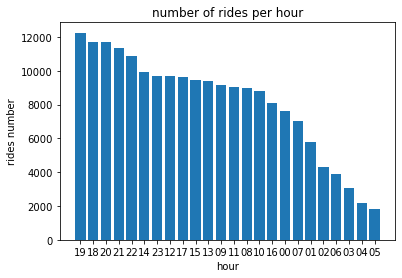

In [52]:
#call the function
plot_visual_1()

##### Question 2: Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

##### Question 3: Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

##### Question 4: Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

##### Question 5: Create a scatter plot that compares tip amount versus distance.

In [53]:

def plot_visual_5():
    #within the query below, outliers (like more than 40 tips has been eliminated to better indicate the correlation between distance and tips)
    QUERY = """
    SELECT distance, tip_amount FROM taxi where tip_amount < 40 
    """
    result5 = db.execute(QUERY).fetchall() #the tuple containing the hour and number of rides

    distance = [ele[0] for ele in result5]
    tip = [ele[1] for ele in result5]
    fig, ax = matplotlib.pyplot.subplots()
    ax.set_title('Scatter plot of distance and tips')
    ax.set_xlabel('distance')
    ax.set_ylabel('tip')
    ax.scatter(distance,tip) 





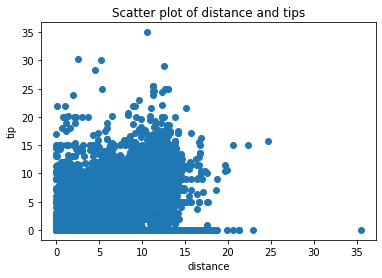

In [54]:
plot_visual_5()

##### Question 6: Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.


In [94]:
def plot_visual_6(taxi_data, hourly_weather_data):
    hourly_weather_data['hour'] = hourly_weather_data['tpep_pickup_datetime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')).dt.to_period('H')
    taxi_data['hour'] = taxi_data['tpep_pickup_datetime'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')).dt.to_period('H')
    taxi_data = taxi_data[taxi_data['tip_amount'] <= 30] #removing outliers
    tip_preciption = pd.merge(hourly_weather_data[['hour', 'HourlyPrecipitation']], taxi_data[['hour', 'tip_amount']], how = 'inner', on = 'hour')
    fig, ax = matplotlib.pyplot.subplots()
    ax.set_title('Scatter plot of preciption and tips')
    ax.set_xlabel('preciption')
    ax.set_ylabel('tip')
    ax.scatter(tip_preciption['HourlyPrecipitation'],tip_preciption['tip_amount']) 


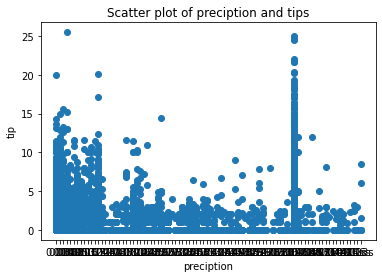

In [95]:
plot_visual_6(taxi_data, hourly_weather_data)

##### Bonus 1: add animation to ploting (question 1 in part 4)

In [ ]:
#For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins. (Visualize)
#apply the part 1's query in question 3
def plot_visual_1():
    result1 = db.execute(QUERY_1).fetchall() #the tuple containing the hour and number of rides

    hours = [ele[0] for ele in result1]
    rides = [ele[1] for ele in result1]
    fig, ax = matplotlib.pyplot.subplots()
    ax.set_title('number of rides per hour')
    ax.set_xlabel('hour')
    ax.set_ylabel('rides number')
    ax.bar(hours,rides) 

In [105]:
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib qt
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.set_ylim(0, 13000)
plt.style.use("seaborn")

result1 = db.execute(QUERY_1).fetchall() #the tuple containing the hour and number of rides

hours = [ele[0] for ele in result1]
rides = [ele[1] for ele in result1]

lst1=[0, rides[0]/3, 2*rides[0]/3, rides[0]]
lst2=[0, rides[1]/3, 2*rides[1]/3, rides[1]]
lst3=[0, rides[2]/3, 2*rides[2]/3, rides[2]]
lst4=[0, rides[3]/3, 2*rides[3]/3, rides[3]]
lst5=[0, rides[4]/3, 2*rides[4]/3, rides[4]]
lst6=[0, rides[5]/3, 2*rides[5]/3, rides[5]]
lst7=[0, rides[6]/3, 2*rides[6]/3, rides[6]]
lst8=[0, rides[7]/3, 2*rides[7]/3, rides[7]]
lst9=[0, rides[8]/3, 2*rides[8]/3, rides[8]]
lst10=[0, rides[9]/3, 2*rides[9]/3, rides[9]]
lst11=[0, rides[10]/3, 2*rides[10]/3, rides[10]]
lst12=[0, rides[11]/3, 2*rides[11]/3, rides[11]]
lst13=[0, rides[12]/3, 2*rides[12]/3, rides[12]]
lst14=[0, rides[13]/3, 2*rides[13]/3, rides[13]]
lst15=[0, rides[14]/3, 2*rides[14]/3, rides[14]]
lst16=[0, rides[15]/3, 2*rides[15]/3, rides[15]]
lst17=[0, rides[16]/3, 2*rides[16]/3, rides[16]]
lst18=[0, rides[17]/3, 2*rides[17]/3, rides[17]]
lst19=[0, rides[18]/3, 2*rides[18]/3, rides[18]]
lst20=[0, rides[19]/3, 2*rides[19]/3, rides[19]]
lst21=[0, rides[20]/3, 2*rides[20]/3, rides[20]]
lst22=[0, rides[21]/3, 2*rides[21]/3, rides[21]]
lst23=[0, rides[22]/3, 2*rides[22]/3, rides[22]]
lst24=[0, rides[23]/3, 2*rides[23]/3, rides[23]]

palette = list(reversed(sns.color_palette("seismic", 24).as_hex()))

y1, y2, = [], []
def animate(i):
    y1=lst1[i]
    y2=lst2[i]
    y3=lst3[i]
    y4=lst4[i]
    y5=lst5[i]
    y6=lst6[i]
    y7=lst7[i]
    y8=lst8[i]
    y9=lst9[i]
    y10=lst10[i]
    y11=lst11[i]
    y12=lst12[i]
    y13=lst13[i]
    y14=lst14[i]
    y15=lst15[i]
    y16=lst16[i]
    y17=lst17[i]
    y18=lst18[i]
    y19=lst19[i]
    y20=lst20[i]
    y21=lst21[i]
    y22=lst22[i]
    y23=lst23[i]
    y24=lst24[i]

    
    plt.bar(hours, [y1,y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21, y22, y23, y24], color=palette)

plt.title("Animation", color=("blue"))
ani = FuncAnimation(fig, animate, interval=100)


#######please note that you need to close the animation picture in order to let the program finish!!!!!!!


Traceback (most recent call last):
  File "/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1198, in _on_timer
    ret = func(*args, **kwargs)
  File "/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py", line 1408, in _step
    still_going = super()._step(*args)
  File "/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py", line 1107, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py", line 1126, in _draw_next_frame
    self._draw_frame(framedata)
  File "/Users/wesley/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py", line 1720, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "/var/folders/_s/18nnk14x26xd0hw8_j7261xw0000gn/T/ipykernel_88054/1756361807.py", line 45, in animate
    y1=lst1[i]
IndexError: list index out of range
Traceback (most r